# Predictor

## Load Data

In [1]:
#@title Imports
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Make Desired Dataset Changes in Cell Below (Optional)

See [`README.md`](../README.md) for options and instructions.

In [2]:
#@title Import Tensor Data
# Train
masks = torch.load('data/masks.pt')                                                     # Line 0

# masks1 = torch.load('data/masks.pt')                                                  # Line 1
# masks2 = torch.load('data/unlabeled_masks.pt')                                        # Line 2
# masks = torch.cat((masks1, masks2), dim=0)                                            # Line 3

# masks = masks[:11000, :16, :, :]                                                      # Line 4

# # Validation
val_masks = torch.load('data/val_masks.pt')

print("Train masks:", masks.shape)
print("Val masks:", val_masks.shape)

## Datasets and Loaders

In [4]:
#@title Dataset Class & Loaders
class MaskDataset(Dataset):
  def __init__(self, masks, transform=None):
    self.masks = masks#.reshape(-1, 22, 160, 240)
    self.t = transforms.RandomHorizontalFlip()
  
  def __len__(self):
    return len(self.masks)

  def __getitem__(self, index):
    msk = self.masks[index]
    msk = self.t(msk) # Random Horizontal Flip: augmentation

    return msk

# Datasets
train_dataset = MaskDataset(masks)
val_dataset = MaskDataset(val_masks)

# Data Loaders
batch_size = 16 # 64 leads to memory shortage on my system

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

### Some Data Visualization across 22 frames

torch.Size([16, 22, 160, 240])


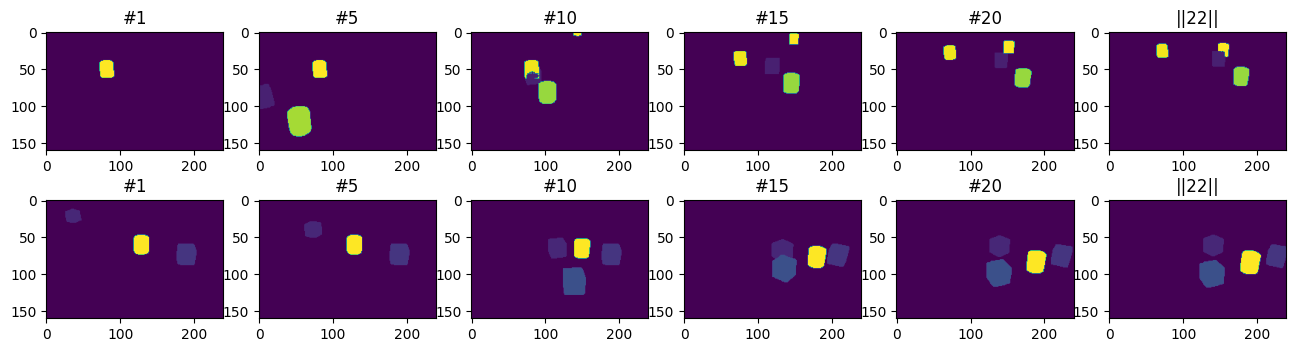

In [5]:
#@title Visualize
example = next(iter(val_loader))
# mask, targ = [x for x in example]
mask = example

print(mask.shape)
# print(targ.shape)

fig, axes = plt.subplots(2, 6, figsize=(16, 4))
for i in range(2): # Load 2 rows/sequences
    axes[i][0].imshow(mask[i][0])
    axes[i][1].imshow(mask[i][4])
    axes[i][2].imshow(mask[i][9])
    axes[i][3].imshow(mask[i][14])
    axes[i][4].imshow(mask[i][19])
    axes[i][0].set_title("#1")
    axes[i][1].set_title("#5")
    axes[i][2].set_title("#10")
    axes[i][3].set_title("#15")
    axes[i][4].set_title("#20")

    axes[i][5].imshow(mask[i][21])
    axes[i][5].set_title("||22||")
plt.show()

## UNet - Predictor

Code inspired by: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [6]:
#@title Conv Block
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [7]:
#@title Encoder Block
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [8]:
#@title Decoder Block
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [9]:
#@title UNet Block
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed_dim = 32
        self.emb = nn.Embedding(49, self.embed_dim)

        # Encoder
        self.e1 = encoder_block(11*self.embed_dim, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classifier
        self.outputs = nn.Conv2d(64, 49, kernel_size=1, padding=0)

    def forward(self, inputs): # B x S x H x W
        check = True

        for i in range(11): # Embed each image in sequence
          temp = inputs[:, i, :, :]  # B x H x W
          temp = self.emb(temp)  # B x H x W x 32
          temp = temp.permute(0, 3, 1, 2)  # B x 32 x H x W 

          if check:
            x = temp
            check = False
          else:
            x = torch.cat((x, temp), dim=1)

        # Encoder
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Bottleneck
        b = self.b(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        # Classifier
        outputs = self.outputs(d4).unsqueeze(1)

        return outputs

### (Option 1) Create a New Model

In [11]:
#@title New Model
model = UNet().to(device)

# Test forward pass
input_tensor = train_dataset[0].unsqueeze(0)[:, :11, :, :].to(device).long()
output = model(input_tensor)
print(output.shape)
print(f"Number of Weights: {sum(p.numel() for p in model.parameters()):,}")

torch.Size([1, 1, 49, 160, 240])
Number of Weights: 31,249,233


### (Option 2) Load a Trained Model

In [ ]:
#@title Load a Model
model = UNet().to(device)
model.load_state_dict(torch.load("./predictor_models/predictor.pth")) # LOAD TRAINED MODEL

# Test forward pass
input_tensor = train_dataset[0].unsqueeze(0)[:, :11, :, :].to(device).long()
output = model(input_tensor)
print(output.shape)
print(f"Number of Weights: {sum(p.numel() for p in model.parameters()):,}")

## Training

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

result = {"train": [], "val": []} # For tracking loss
best_val = -1 # Negative as real val will be positive

In [13]:
#@title Display Mask Output Comparison
def display_comp(model, index, ds="val"):
  if ds == "val":
    ex = next(iter(val_loader))
    seq = ex[index][:11]
    targ = ex[index][11, :, :]
  elif ds == "train":
    ex = next(iter(train_loader))
    seq = ex[index][:11]
    targ = ex[index][11, :, :]

  pred_mask = model(seq.unsqueeze(0).to(device).long()).cpu().squeeze(0).squeeze(0)

  fig, axes = plt.subplots(1, 2, figsize=(6, 3))
  axes[0].imshow(targ, vmin=0, vmax=48)
  axes[1].imshow(pred_mask.argmax(0), vmin=0, vmax=48)
  plt.show()

In [ ]:
#@title Training
from tqdm.notebook import tqdm

num_epochs = 10
num_pred = 11 # Num pred shoud be 11 if the normal-sized dataset is used (22 frames per video)
              # Any alterations to the data shape should be reflected here
              # num_pred == num_frames_per_video - 11
              # We used this in our 'unlabeled' implementation as we shrank the dataset to a size of 
              # size (14000, 22, 160, 240) to a size of (14000, 16, 160, 240) -> giving num_pred = 16 - 11 = 5
              # Our reasons for this are explained in our report

# Loss + Update Model function
def get_loss(seq, targ, optimizer=None):
  pred_mask = model(seq.long()).squeeze(1)
  loss = criterion(pred_mask, targ.long())

  if optimizer is not None:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss

# Training loop
for epoch in tqdm(range(1, num_epochs+1), leave=False): # Train on several epochs
    total_train_loss = 0
    model.train()
    for batch in tqdm(train_loader, leave=False):
        for i in range(num_pred): # Generate next image 'num_pred' times | This is where we shift the model inputs
            mask_seq = batch[:, i:11+i, :, :].to(device)
            targ = batch[:, 11+i, :, :].to(device)
            total_train_loss += get_loss(mask_seq, targ, optimizer=optimizer)

    train_loss = total_train_loss.item() / (num_pred*len(train_loader))
    result["train"].append(train_loss) # Record loss for post-training visualization

    # Test model on validation
    with torch.no_grad():
        val_result = 0
        count = 0
        model.eval()
        total_val_loss = 0
        for batch in val_loader:
            for i in range(11): # Generate next image 10 times | This is where we shift the model inputs
                mask_seq_val = batch[:, i:11+i, :, :].to(device)
                targ_val = batch[:, 11+i, :, :].to(device)
                total_val_loss += get_loss(mask_seq_val, targ_val) * mask_seq_val.size(0)
                count += mask_seq_val.size(0)

        val_result = total_val_loss.item() / count
        result["val"].append(val_result) # Record loss for post-training visualization
        print(f"Epoch {epoch} | Train: {train_loss:.4f} | Val: {val_result:.4f}") # Print Epoch losses

        if (best_val == -1) or (val_result < best_val):
            best_val = val_result
            torch.save(model.state_dict(), "./predictor_models/best_predictor.pth") # Save the best model as 'best_predictor.pth'

        display_comp(model, 3) # Display prediction example on validation (function defined in cell above)
    scheduler.step(total_val_loss) # Send validation loss to lr_scheduler

## Results

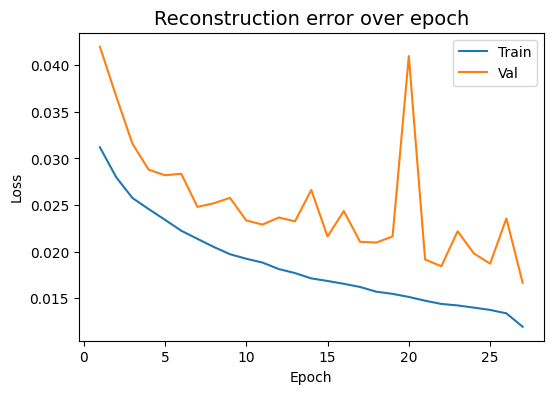

In [41]:
# View Training Progress
fig_prog = plt.figure(figsize=(6,4))

plt.plot(range(1, len(result["train"])+1), result["train"], label="Train")
plt.plot(range(1, len(result["val"])+1), result["val"], label="Val")
plt.title("Reconstruction error over epoch", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# View a specific example
example_num = 3
model.eval()
display_comp(model, example_num)